# Enrichment from FRESCO
7th June 2022 

This notebook is for comparing the enrichment between FRESCO models trained on X-ray fragment-protein complexes vs docked ones

### Load docking conformations

In [1]:
from rdkit.Chem import PandasTools

sdfFile = '/home/wjm41/ml_physics/frag-pcore-screen/data/COVID_Moonshot_activity data_2021-03-22_noncovalent_docked.sdf'
df_docking = PandasTools.LoadSDF(
    sdfFile, idName='canonical_CID', smilesName='SMILES', molColName='mol')


INFO:rdkit:Enabling RDKit 2022.03.1 jupyter extensions


In [2]:
from distutils.util import strtobool

df_docking = df_docking.dropna(subset=['acrylamide'])
df_docking['acrylamide'] = df_docking['acrylamide'].apply(
    strtobool).astype(bool)
df_docking['chloroacetamide'] = df_docking['chloroacetamide'].apply(
    strtobool).astype(bool)

df_docking = df_docking.query('~chloroacetamide & ~acrylamide')


Generate pharmacophore dataframe from conformers
parse conformers

In [4]:
from fresco.featurise import return_pcore_dataframe_for_list_of_mols

moonshot_pcore_dataframe = return_pcore_dataframe_for_list_of_mols(df_docking['mol'].values)
moonshot_pcore_dataframe


100%|██████████| 2538/2538 [00:42<00:00, 60.37it/s]


,pcore,smiles,mol_id,coord_x,coord_y,coord_z
0,Donor,C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...,0,8.706100,-3.282500,24.817800
0,Donor,C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...,0,6.785400,-4.799400,26.467600
0,Donor,C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...,0,7.780500,-0.126000,21.171800
0,Acceptor,C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...,0,6.594600,0.190600,17.701700
0,Acceptor,C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...,0,9.923300,0.106100,20.227800
...,...,...,...,...,...,...
0,Acceptor,O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1coc...,2537,5.232900,-7.223200,27.364600
0,Aromatic,O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1coc...,2537,11.660640,0.511120,24.741700
0,Aromatic,O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1coc...,2537,6.833800,-5.037117,27.731300
0,Aromatic,O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1coc...,2537,5.819533,-0.802667,24.718817


Generate pharmacophore 2-body distribution

In [5]:
from fresco.featurise import return_default_pharmacophore_pairs, calculate_pairwise_distances_between_pharmacophores_for_a_single_ligand

pcore_pairs = return_default_pharmacophore_pairs()

moonshot_pair_distributions = []
for index in tqdm(moonshot_pcore_dataframe.mol_id.unique()):
    pair_distribution_for_this_ligand = {}
    
    for pcore_pair in pcore_pairs:
        core_a,core_b = pcore_pair.split('-')
        pair_distribution_for_this_ligand[pcore_pair] = calculate_pairwise_distances_between_pharmacophores_for_a_single_ligand(
            moonshot_pcore_dataframe.query('mol_id == @index'), core_a, core_b)

    moonshot_pair_distributions.append(pair_distribution_for_this_ligand)


100%|██████████| 2538/2538 [01:24<00:00, 29.91it/s]


Load fragment KDEs

In [6]:
import dill as pickle
from fresco.model import load_kde_model

pickle_dir = '/home/wjm41/ml_physics/frag-pcore-screen/data/EnamineREAL/pickles/'
xray_kde_mpro = 'kde_dict_spl_mpro.pickle'
xray_kde_dict = pickle.load(open(pickle_dir+xray_kde_mpro, 'rb'))

docked_kde_mpro = '/home/wjm41/ml_physics/frag-pcore-screen/data/kde_on_docked_mpro_frags.pkl'
docked_kde_dict = load_kde_model(docked_kde_mpro)

Score moonshot mols with KDEs

,canonical_CID,SMILES,mol,series,Chemgauss4 Score,f_avg_pIC50,f_avg_IC50,chloroacetamide,acrylamide,Number of Confs,...,r_avg_IC50,relative_solubility_at_100_uM,relative_solubility_at_20_uM,f_inhibition_at_50_uM,f_inhibition_at_20_uM,r_inhibition_at_20_uM,trypsin_IC50,frag_id,xray_fresco_score,docked_fresco_score
1,EDG-MED-ba1ac7b9-15,C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",3-aminopyridine-like,-12.6986,5.20921,6.17716,False,False,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.899725,-2.914773
2,MAT-POS-9ff17035-2,O=C(Cc1cc(Cl)cc(Oc2cccc(=O)[nH]2)c1)Nc1cncc2cc...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",3-aminopyridine-like,-12.43,5.70429,1.97563,False,False,500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.803965,-2.569468
3,EDJ-MED-8c98ee63-2,Cn1ccc(CNC[C@@]2(C(=O)Nc3cncc4ccccc34)CCOc3ccc...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",3-aminopyridine-like,-12.3919,6.09539,0.802811,False,False,500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.373098,-3.000755
4,ALP-POS-64a710fa-1,O=C(Cc1cncc2ccccc12)N(CCC1CCCCC1)Cc1cccs1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",NaN,-12.3789,5.00607,9.86113,False,False,500,...,3.02151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.023161,-2.900700
5,BAR-COM-4e090d3a-3,Cc1ccccc1CNc1ccccc1NC(=O)[C@@H](O)c1cccnc1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",3-aminopyridine-like,-12.3516,NaN,NaN,False,False,500,...,NaN,0.94,0.95,7.28047,-0.0560025,4.5875,NaN,NaN,-2.959190,-6.074448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.253183,-2.838171
2329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.079938,-2.833808
2340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.864958,-2.520912
2354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.064349,-2.826723

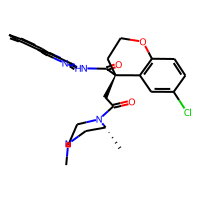
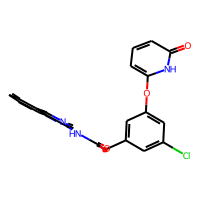
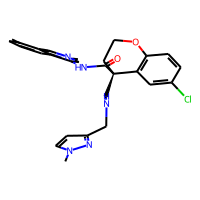
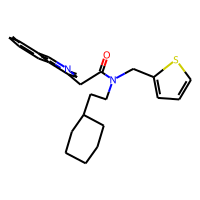
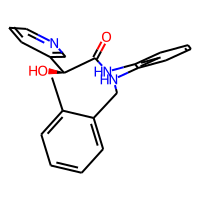

In [7]:
import numpy as np
import pandas as pd
from fresco.model import score_dist

def score_with_kde(kde_model, col_name):
    
    df_docking[col_name] = -100.0
    for i, pair_dist in enumerate(moonshot_pair_distributions):
        score_df_for_this_molecule = pd.DataFrame(columns=pcore_pairs)
        
        for pcore_combination in pcore_pairs:
            kde_for_this_combination = kde_model[pcore_combination]
            # print(pair_dist[pcore_combination])
            pcore_dist = pair_dist[pcore_combination].reshape(
                -1, 1)
            pcore_score = score_dist(kde_for_this_combination, pcore_dist)
            score_df_for_this_molecule.at[0, pcore_combination] = pcore_score

        scores = score_df_for_this_molecule[pcore_pairs].to_numpy().astype(
            float)
        scores[np.isnan(scores)] = -100
        processed_score_for_this_molecule = np.nanmean(scores)
        df_docking.at[i, col_name] = processed_score_for_this_molecule
        
score_with_kde(xray_kde_dict, 'xray_fresco_score')
score_with_kde(docked_kde_dict, 'docked_fresco_score')
df_docking


Average fragment scores over conformers

In [8]:
df_docking.f_avg_IC50 = df_docking.f_avg_IC50.astype(float)
df_docking['Chemgauss4 Score'] = df_docking['Chemgauss4 Score'].astype(float)

columns_to_keep = ['canonical_CID', 'Chemgauss4 Score', 'f_avg_IC50', 'xray_fresco_score', 'docked_fresco_score']
df_docking = df_docking[columns_to_keep]
df_docking_grouped = df_docking.groupby(by=df_docking.canonical_CID).mean()
df_docking_grouped['canonical_CID'] = df_docking_grouped.index

df_docking_grouped['hit'] = df_docking_grouped['f_avg_IC50'] < 5
print(df_docking_grouped[['hit', 'f_avg_IC50', 'Chemgauss4 Score', 'xray_fresco_score', 'docked_fresco_score']])


                       hit  f_avg_IC50  Chemgauss4 Score  xray_fresco_score  \
canonical_CID                                                                 
AAR-POS-0daf6b7e-23  False         NaN          -5.71945          -4.103888   
AAR-POS-5507155c-1   False     99.5000          -5.24347          -3.116271   
AAR-POS-8a4e0f60-1   False         NaN          -9.23545          -3.203560   
AAR-POS-8a4e0f60-10  False         NaN          -6.75070          -2.887218   
AAR-POS-8a4e0f60-2   False         NaN          -9.57557          -2.885707   
...                    ...         ...               ...                ...   
WIL-MOD-03b86a88-2   False     19.0909          -8.93996          -3.490884   
WIL-MOD-03b86a88-4   False     15.9534          -9.98616          -2.909079   
WIL-MOD-03b86a88-5   False     21.7972          -9.32327          -3.048949   
WIL-MOD-03b86a88-6   False     11.2566          -9.12435          -3.073355   
WIL-UNI-2e73223c-4   False     99.5000          -9.2

Getting submission dates

In [9]:
dateFile = '/home/wjm41/ml_physics/frag-pcore-screen/data/20220122_moonshot_submissions_data_for_alpha.csv'
df_date = pd.read_csv(dateFile)

def remove_suffix(id):
    id_separated = id.split('-')[:-1]
    new_id = '-'.join(id_separated)
    return new_id


df_docking_grouped['submission_id'] = df_docking_grouped['canonical_CID'].apply(remove_suffix)
df_merged = df_docking_grouped.merge(df_date, on='submission_id')



Enrichment against time

In [12]:
from ipywidgets import interact
from scipy.stats import spearmanr as spear
import plotly.express as px

from fresco.frag_funcs import calculate_enrichment_for_df

def plotly_enrichment_docking_vs_fresco(df_to_plot, title='Not Specified!'):
    n_list = np.logspace(start=np.log10(5), stop=2, num=20)
    EF_docking = [calculate_enrichment_for_df(
        df_to_plot, n=int(n), index='hit', score='Chemgauss4 Score', ascending=True) for n in n_list]
    EF_xray = [calculate_enrichment_for_df(
        df_to_plot, n=int(n), index='hit', score='xray_fresco_score', ascending=False) for n in n_list]
    
    EF_docked = [calculate_enrichment_for_df(
        df_to_plot, n=int(n), index='hit', score='docked_fresco_score', ascending=False) for n in n_list]    
    
    orig_prop = len(
        df_to_plot[df_to_plot['hit']])/len(df_to_plot)

    df_dock_ef = pd.DataFrame(list(zip(n_list, EF_docking)), columns=['N', 'EF'])
    df_dock_ef['Method'] = 'Docking'
    df_xray_ef = pd.DataFrame(list(zip(n_list, EF_xray)), columns=[
                                 'N', 'EF'])
    df_xray_ef['Method'] = 'Fresco - Xray'
    df_docked_ef = pd.DataFrame(list(zip(n_list, EF_docked)), columns=[
                                 'N', 'EF'])
    df_docked_ef['Method'] = 'Fresco - Docked'
    df_enrichment = pd.concat([df_dock_ef, df_xray_ef, df_docked_ef])
    
    fig_EF = px.line(df_enrichment, x='N', y='EF',
                     color='Method')

    fig_EF.add_shape(
        type="line", line=dict(dash='dash'),
        x0=min(n_list), y0=1,
        x1=max(n_list), y1=1)
    
    fig_EF.update_layout(
        title_text=f"Enrichment - {title}",
        xaxis_title='N',
        yaxis_title=f'EF <br>n = {len(df_to_plot)} <br> base rate = {orig_prop*100:.1f}%',
        width=800,
    )

    fig_EF.show()


def plot_enrichment_against_time(year, month, day, ic50_threshold):
    date_to_filter = int(f'{year}{month}{day}')
    df_filtered_by_date = df_merged.query('date < @date_to_filter').copy()
    df_filtered_by_date['hit'] = df_filtered_by_date['f_avg_IC50'] < ic50_threshold
    # rho_dock_vs_fresco = spear(df_filtered_by_date['Chemgauss4 Score'].values, df_filtered_by_date['mean_frag_score'].values)[0]
    # rho_ic50_vs_fresco = spear(df_filtered_by_date.dropna()['f_avg_IC50'].values,
    #                  df_filtered_by_date.dropna()['mean_frag_score'].values)[0]
    # rho_ic50_vs_dock = spear(df_filtered_by_date.dropna()['Chemgauss4 Score'].values,
    #                            df_filtered_by_date.dropna()['mean_frag_score'].values)[0]
    # print(f'rho dock vs fresco {rho_dock_vs_fresco:.2f}')
    # print(f'rho dock vs IC50 {rho_ic50_vs_dock:.2f}')
    # print(f'rho fresco vs IC50 {rho_ic50_vs_fresco:.2f}')

    # print(df_filtered_by_date['hit'].value_counts())
    # plot_enrichment_docking_vs_fresco(df_filtered_by_date,
    #                                   title=f'IC50 < {ic50_threshold}uM, rho = {rho_dock_vs_fresco:.2f}\n Moonshot submissions before {day}-{month}-{year} (n={len(df_filtered_by_date)})')
    plotly_enrichment_docking_vs_fresco(df_filtered_by_date,
                                        title=f'IC50 < {ic50_threshold}uM<br>COVID Moonshot submissions before {day}-{month}-{year}')
    return


years_to_choose_from = ['2021', '2020']
months_to_choose_from = [f'0{x}' for x in range(
    1, 10)] + [f'{x}' for x in range(10, 13)]
days_to_choose_from = [f'0{x}' for x in range(
    1, 10)] + [f'{x}' for x in range(10, 31)]
interact(plot_enrichment_against_time,
         year=years_to_choose_from, month=months_to_choose_from, day=days_to_choose_from, ic50_threshold=(0.0, 100.0))


interactive(children=(Dropdown(description='year', options=('2021', '2020'), value='2021'), Dropdown(descripti…

<function __main__.plot_enrichment_against_time(year, month, day, ic50_threshold)>

Let's try pre-filtering with docking

### Customising and formatting enrichment plot to publication quality

(0.0, 6.548684210526315)

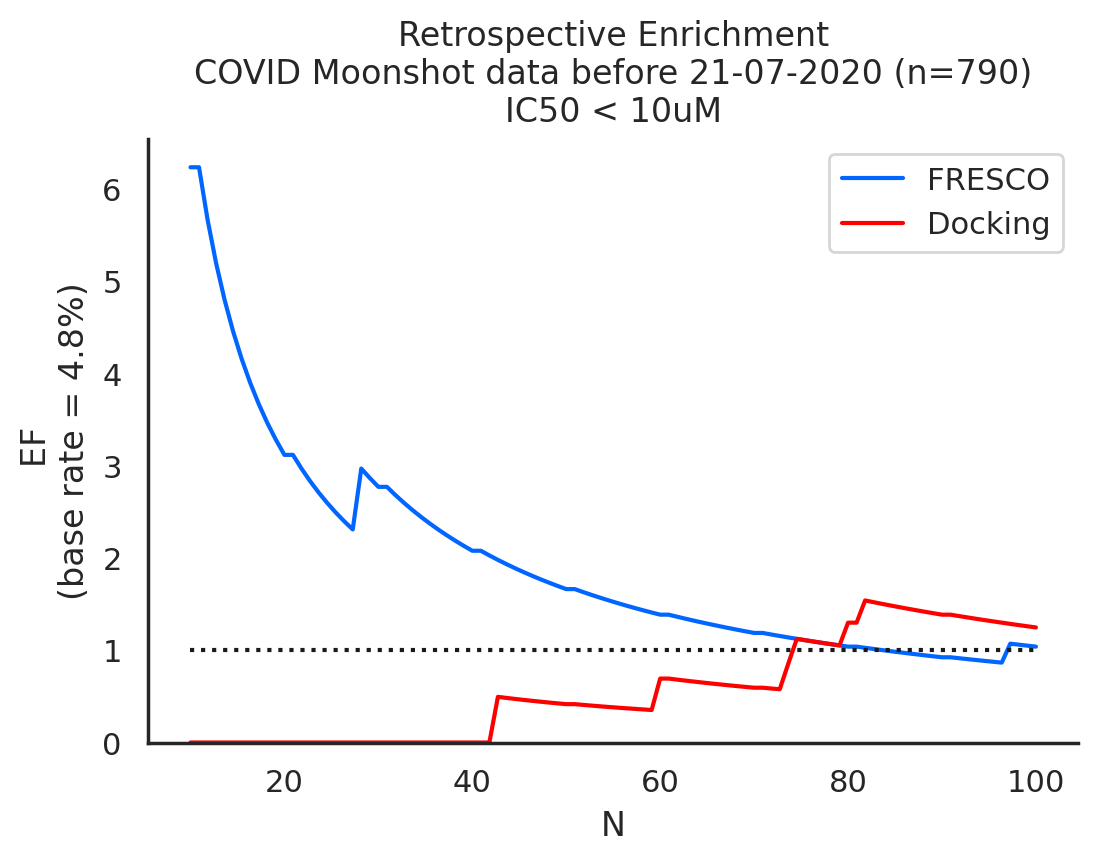

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

year='2020'
month='07'
day='21'
date_to_plot = int(f'{year}{month}{day}')
ic50_threshold = 10

df_filtered_by_date = df_merged.query('date < @date_to_plot').copy()
df_filtered_by_date['hit'] = df_filtered_by_date['f_avg_IC50'] < ic50_threshold

starting_number = 10
n_list = np.logspace(start=np.log10(starting_number), stop=2, num=1000)
n_list = np.linspace(start=starting_number, stop=100, num=100)

EF_docking = [calculate_enrichment_for_df(
    df_filtered_by_date, n=int(n), index='hit', score='Chemgauss4 Score', ascending=True) for n in n_list]
EF_fresco = [calculate_enrichment_for_df(
    df_filtered_by_date, n=int(n), index='hit', score='mean_frag_score', ascending=False) for n in n_list]

orig_prop = len(
    df_filtered_by_date[df_filtered_by_date['hit']])/len(df_filtered_by_date)

sns.set_style('white')


fig = plt.figure(dpi=200)
ax = plt.gca()
df_docking = pd.DataFrame({'N': n_list, 'EF': EF_docking, 'method': 'Docking'})
df_fresco = pd.DataFrame({'N': n_list, 'EF': EF_fresco, 'method': 'FRESCO'})
df_merged_enrichment = pd.concat([df_fresco, df_docking]).reset_index()

sns.lineplot(data=df_merged_enrichment, x='N', y='EF', hue='method', ax=ax, palette=['#0066FF', '#FF0000'])
# plt.plot(n_list, EF_docking, label='dock scores')
# plt.plot(n_list, EF_fresco, label='fresco score')
sns.despine()
plt.plot(n_list, np.ones_like(n_list), 'k:')
plt.legend()
plt.title(f'Retrospective Enrichment\nCOVID Moonshot data before {day}-{month}-{year} (n={len(df_filtered_by_date)})\nIC50 < {ic50_threshold}uM')
plt.ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
# extraticks = [1]
# plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.ylim(bottom=0)

0      4.0
1      4.0
2      4.0
3      4.0
4      4.0
      ... 
85    15.0
86    16.0
87    16.0
88    16.0
89    16.0
Name: EF, Length: 90, dtype: float64
90      3.0
91      3.0
92      4.0
93      4.0
94      4.0
       ... 
175    28.0
176    28.0
177    28.0
178    29.0
179    30.0
Name: EF, Length: 90, dtype: float64


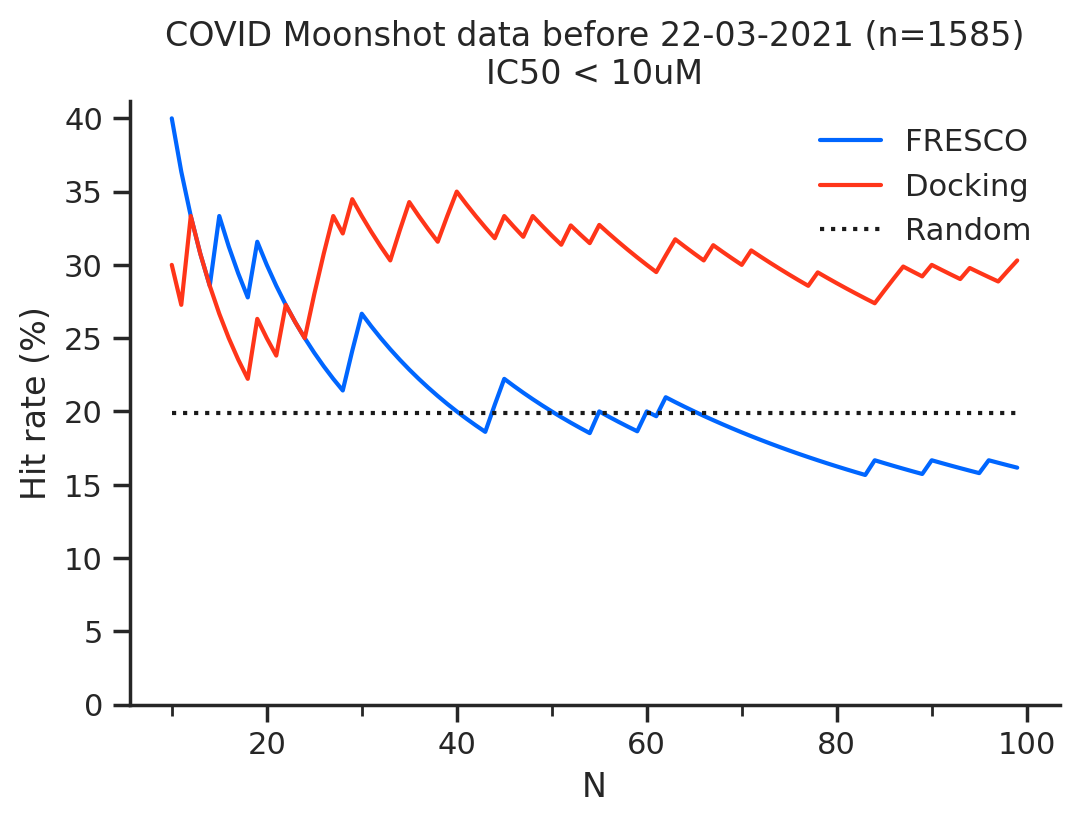

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
year='2021'
month='03'
day='22'
date_to_plot = int(f'{year}{month}{day}')
ic50_threshold = 10

df_filtered_by_date = df_merged.query('date < @date_to_plot').copy()
df_filtered_by_date['hit'] = df_filtered_by_date['f_avg_IC50'] < ic50_threshold

starting_number = 10
stop_number = 100
n_list = np.logspace(start=np.log10(starting_number), stop=np.log10(stop_number), num=1000)
n_list = np.linspace(start=starting_number, stop=stop_number, num=stop_number-starting_number, endpoint=False)

EF_docking = [calculate_enrichment_for_df(
    df_filtered_by_date, n=int(n), index='hit', score='Chemgauss4 Score', ascending=True) for n in n_list]
EF_fresco = [calculate_enrichment_for_df(
    df_filtered_by_date, n=int(n), index='hit', score='mean_frag_score', ascending=False) for n in n_list]

orig_prop = 100*len(
    df_filtered_by_date[df_filtered_by_date['hit']])/len(df_filtered_by_date)

sns.set_style('white')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

fig = plt.figure(dpi=200)
ax = plt.gca()
df_docking = pd.DataFrame({'N': n_list, 'EF': EF_docking, 'method': 'Docking'})
df_fresco = pd.DataFrame({'N': n_list, 'EF': EF_fresco, 'method': 'FRESCO'})

df_merged_enrichment = pd.concat([df_fresco, df_docking]).reset_index()

df_merged_enrichment['EF'] = df_merged_enrichment['EF']*orig_prop

sns.lineplot(data=df_merged_enrichment, x='N', y='EF',
             hue='method', ax=ax, palette=['#0066FF', '#FF3519'])
sns.despine()
plt.plot(n_list, np.ones_like(n_list)*orig_prop, 'k:', label='Random')
ax.xaxis.set_major_locator(MultipleLocator(20))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(10))
plt.legend(loc='upper right',frameon=False)
plt.title(
    f'COVID Moonshot data before {day}-{month}-{year} (n={len(df_filtered_by_date)})\nIC50 < {ic50_threshold}uM')
# plt.title(f'IC50 < {ic50_threshold}uM')
plt.ylabel('Hit rate (%)')
plt.ylim(bottom=0)

print(df_merged_enrichment.query('method == "FRESCO"')['EF']*n_list/100)
print(df_merged_enrichment.query('method == "Docking"')['EF']*n_list/100)


28 May - Updated Title & Axes

0     3.0
1     3.0
2     3.0
3     3.0
4     3.0
     ... 
85    4.0
86    4.0
87    5.0
88    5.0
89    5.0
Name: EF, Length: 90, dtype: float64
90     0.0
91     0.0
92     0.0
93     0.0
94     0.0
      ... 
175    6.0
176    6.0
177    6.0
178    6.0
179    6.0
Name: EF, Length: 90, dtype: float64


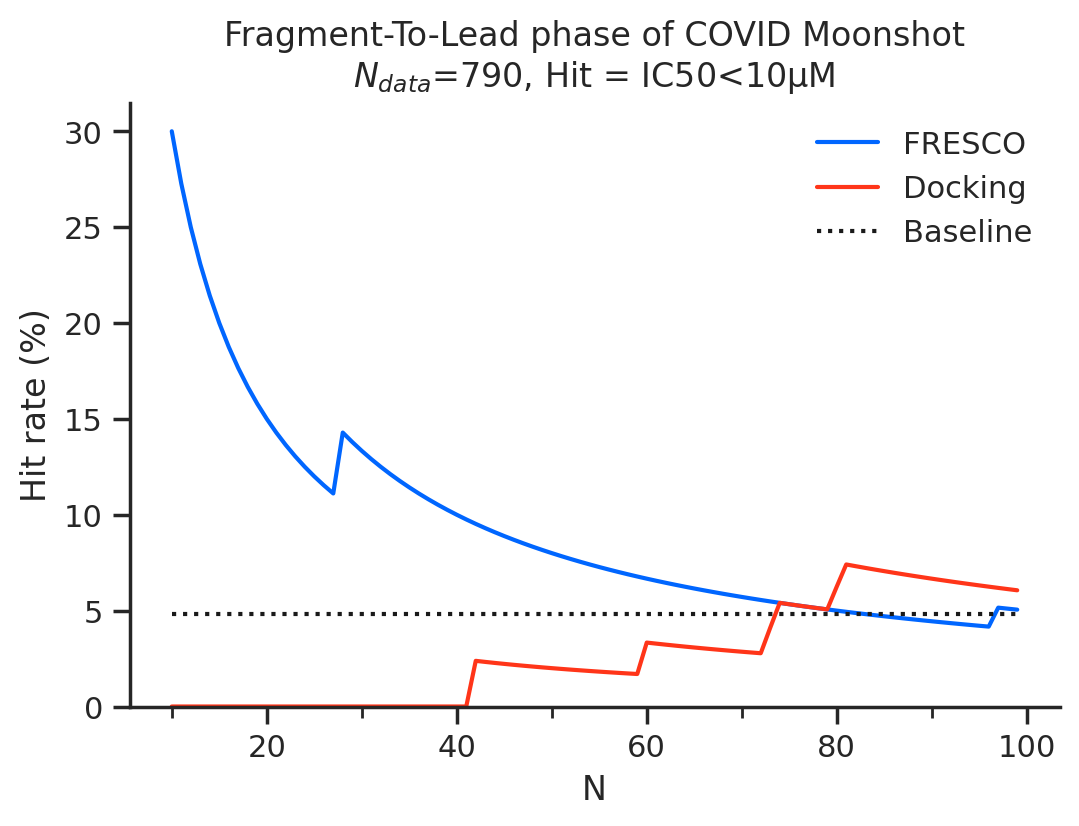

In [ ]:

year='2020'
month='07'
day='21'
date_to_plot = int(f'{year}{month}{day}')
ic50_threshold = 10

df_filtered_by_date = df_merged.query('date < @date_to_plot').copy()
df_filtered_by_date['hit'] = df_filtered_by_date['f_avg_IC50'] < ic50_threshold

starting_number = 10
stop_number = 100
n_list = np.logspace(start=np.log10(starting_number), stop=np.log10(stop_number), num=1000)
n_list = np.linspace(start=starting_number, stop=stop_number, num=stop_number-starting_number, endpoint=False)

EF_docking = [calculate_enrichment_for_df(
    df_filtered_by_date, n=int(n), index='hit', score='Chemgauss4 Score', ascending=True) for n in n_list]
EF_fresco = [calculate_enrichment_for_df(
    df_filtered_by_date, n=int(n), index='hit', score='mean_frag_score', ascending=False) for n in n_list]

orig_prop = 100*len(
    df_filtered_by_date[df_filtered_by_date['hit']])/len(df_filtered_by_date)

sns.set_style('white')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

fig = plt.figure(dpi=200)
ax = plt.gca()
df_docking = pd.DataFrame({'N': n_list, 'EF': EF_docking, 'method': 'Docking'})
df_fresco = pd.DataFrame({'N': n_list, 'EF': EF_fresco, 'method': 'FRESCO'})

df_merged_enrichment = pd.concat([df_fresco, df_docking]).reset_index()

df_merged_enrichment['EF'] = df_merged_enrichment['EF']*orig_prop

sns.lineplot(data=df_merged_enrichment, x='N', y='EF',
             hue='method', ax=ax, palette=['#0066FF', '#FF3519'])
sns.despine()
plt.plot(n_list, np.ones_like(n_list)*orig_prop, 'k:', label='Baseline')
ax.xaxis.set_major_locator(MultipleLocator(20))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(10))
plt.legend(loc='upper right',frameon=False)
plt.title(
    f'Fragment-To-Lead phase of COVID Moonshot\n$N_{{{"data"}}}$={len(df_filtered_by_date)}, Hit = IC50<{ic50_threshold}µM')
plt.ylabel(f'Hit rate (%)')
plt.ylim(bottom=0)

print(df_merged_enrichment.query('method == "FRESCO"')['EF']*n_list/100)
print(df_merged_enrichment.query('method == "Docking"')['EF']*n_list/100)
